# 다른 토크나이저 사용해보기

1. 문제 파악
2. 데이터 탐색  
    - 데이터 시각화
3. 데이터 전처리 
    - 텍스트 데이터 전처리
    - 임베딩
4. 학습
    - 여러 모델 성능 비교
    - 모델 적용
        - test data 임베딩
        - 결과 예측
6. 모델 개선
    - 모델 확정
    - 파라미터 튜닝 (그리드 서치)
    - 결과 예측

# 1. 문제 파악

* Hashcode 사이트의 질문글
:개발자들을 위한 무료 QnA 사이트로 한글인 질문과 전공용어인 영어, 코드의 내용들이 섞여 있는 코퍼스
   : 이러한 특성 때문에 타 말뭉치와 다른 점이 있다면,  
     
    (1) 프로그래밍 전공 용어가 들어간다.   
        : 딥러닝을 사용할 경우 wiki 백과에 각 언어의 설명이나 각종 documentation으로 코퍼스를 수집, pre-trained 된 모델을 가져와 임베딩을 fine-tunning 시킬 수 있다. 하지만 해당 문제는 데이터 개수가 적은 편이어서 외부 코퍼스가 문제 코퍼스보다 커질 우려가 있다.  
        : 분류를 각 (프로그래밍) 언어 별로 하게 되어 있다.
            => 언어에 따라, 타 언어와 유사한 토큰이 등장할 수 있다.
            ==> 따라서 tf-idf 방식으로 임베딩을 진행한다.
    (2) 사용자가 생성하는 것은 정규화된 언어(뉴스 등)가 아니다.
        : 오타나 이모티콘(ㅠㅠ, ㅋㅋ, 등)이 있다.
        : 전공용어는 영어로 질문은 한글로 적는 등, 두 개의 언어가 혼합되어 있다.
    (3) 답을 알려줄만한 노골적인 키워드는 특수문자로 제거되었다. (ex: 파이썬 질문 있어요 -> $$$ 질문 있어요)

필요한 모듈 임포드

In [1]:
# 데이터 처리에 필요한 모듈 임포트
import sentencepiece as spm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 기계학습에 필요한 모듈 임포드
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

# 멀티 라벨 분류 모델 임포트
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

데이터 다운로드

In [2]:
path = 'C:\Python\Ground\data\hashcode\hashcode_classification2020_{}.csv'
load = lambda x: pd.read_csv(path.format(x))

In [3]:
sample = load('sample')
test = load('test')
train = load('train')

In [4]:
label_dict = {1:'C',2:'C++',3:'java',4:'javascript', 5:'python'}
label_names = list(label_dict.values())

In [7]:
def pre(text):
    # 공백 제거, ㅠㅠ ㅋㅋ 등의 감정 표현 이모티콘 제거, 숫자 제거, 이미지 제거
    # 괄호나 :, ; 등의 문자는 각 언어의 특징점이 될 수 있어 그대로 놔둠
    stop1 = re.compile(r'[\t\r\n\v\f,]+')
    stop2 = re.compile(r'[?!#`ㄱ-ㅎㅏ-ㅣ]+|[0-9]+.?[0-9]*|  |(\.|\*|~|;|\| ){2,}|(_|-|=|/|\||\+){4,}')
    stop3 = re.compile(r'\[이미지\]\[?|\[\:|http[a-zA-Z\.:/\-\=]+[(png)|(jpg)|(jpeg)]')

    text = re.sub(stop1, ' ', text)
    text = re.sub(stop2,'', text)
    text = re.sub(stop3,'', text)
    return text

# 주어진 코퍼스를 각 라벨 별로 분류하여, 전체를 한 문서로 보고 데이터 탐색
def make_doc(label_num):
    # 5개 라벨을 기준으로 5개의 문서 만들기
    total = train[train.label==label_num].title+' '+train[train.label==label_num].content
    text = ''
    for i in total:
        text +=' '+str(i)
    text = pre(text)
    return text

def top_k(label,k):
    doc = make_doc(label)
    vect = CountVectorizer().fit([doc])
    count = vect.transform([doc]).toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]
    feature_name = np.array(vect.get_feature_names())[idx]
    print(list(zip(feature_name, count))[:k])

In [8]:
d1 = make_doc(1)

In [12]:
spm.SentencePieceTrainer.Train('--input=C:\Python\Ground\data\hashcode\hashcode_classification2020_train.csv --model_prefix=m --vocab_size=1000')

True

In [13]:
sp = spm.SentencePieceProcessor()
sp.Load("m.model")

True

In [19]:
sp.EncodeAsPieces(d1[:100])

['▁$$$',
 '▁',
 '순',
 '서',
 '정',
 '리',
 '▁',
 '오',
 '류',
 '▁',
 '질',
 '문',
 '▁//',
 '▁$$$',
 '▁',
 'in',
 'c',
 'l',
 'u',
 'de',
 '▁<',
 'st',
 'd',
 'i',
 'o',
 '.',
 'h',
 '>',
 '▁',
 'in',
 'c',
 'l',
 'u',
 'de',
 '▁<',
 'st',
 'd',
 'li',
 'b',
 '.',
 'h',
 '>',
 '▁',
 'in',
 'c',
 'l',
 'u',
 'de',
 '▁<',
 't',
 'i',
 'me',
 '.',
 'h',
 '>',
 '▁int',
 '▁',
 'm',
 'a',
 'in',
 '()',
 '▁{',
 '▁int',
 '▁',
 'A',
 'r',
 'r',
 'R',
 'o']

유의미한 토크나이징이 되지 않는다. BPE 방식을 학습하기에는 작은 사이즈의 코퍼스가 아닌가 싶다.  
기존에 학습되어 있는 vocab을 불러와 보자

In [24]:
spm.SentencePieceTrainer.Train('--input=C:\Python\Ground\data\hashcode\hashcode_classification2020_train.csv --model_prefix=mbpe --vocab_size=1000 --model_type=bpe')

True

In [25]:
sp.Load("mbpe.model")

True

In [26]:
sp.EncodeAsPieces(d1[:100])

['▁$$$',
 '▁',
 '순',
 '서',
 '정',
 '리',
 '▁',
 '오',
 '류',
 '▁',
 '질',
 '문',
 '▁//',
 '▁$$$',
 '▁',
 'in',
 'c',
 'l',
 'u',
 'de',
 '▁<',
 'st',
 'd',
 'i',
 'o',
 '.',
 'h',
 '>',
 '▁',
 'in',
 'c',
 'l',
 'u',
 'de',
 '▁<',
 'st',
 'd',
 'li',
 'b',
 '.',
 'h',
 '>',
 '▁',
 'in',
 'c',
 'l',
 'u',
 'de',
 '▁<',
 't',
 'i',
 'me',
 '.',
 'h',
 '>',
 '▁int',
 '▁',
 'ma',
 'in',
 '()',
 '▁{',
 '▁int',
 '▁',
 'A',
 'r',
 'r',
 'R',
 'o']

In [27]:
spm.SentencePieceTrainer.Train('--input=C:\Python\Ground\data\hashcode\hashcode_classification2020_train.csv --model_prefix=word --vocab_size=1000 --model_type=word')

True

In [28]:
sp.Load("word.model")

True

In [29]:
sp.EncodeAsPieces(d1[:100])

['▁$$$',
 '▁순서정리',
 '▁오류',
 '▁질문',
 '▁//',
 '▁$$$',
 '▁include',
 '▁<stdio.h>',
 '▁include',
 '▁<stdlib.h>',
 '▁include▁<time.h>',
 '▁int',
 '▁main()',
 '▁{',
 '▁int',
 '▁ArrRo']

조금 낫군..

In [30]:
doc1, doc2, doc3, doc4, doc5 = make_doc(1), make_doc(2), make_doc(3), make_doc(4), make_doc(5)

In [17]:
# 문서 토큰화를 미리 진행해보고, '질문글'의 특성 상 나타날 수 밖에 없는 토큰들을 stop_words로 추가한다.
stoplist = ['은','는','이','가','을','를','안','못','의','에서','에는','에서는',
            '로','으로','만','그','같이','다','라는','게','라고',
            '왜','이런','저런','문제','질문',
            '와','과','또는','도',
            '죠',
            '되다','되어다',
            '경우',
            '이렇게', '이렇다', '오다', '가다','늘다',
            '아래','다음',
            '코드','변수','발생','에러','오류','뜨다',
            '해보다','해주다',
            '이다','있다','않다','없다','아니다','싶다','하다','어떻다','모르다',
            '궁금하다','도움','필요하다','부탁드리다','안녕하다','감사하다',
            '예','들다'
            ]

In [32]:
tokenizer = lambda x:sp.EncodeAsPieces(x)

In [33]:
tfidf_corpus = [doc1, doc2, doc3, doc4, doc5]
tfidf_vectorizer = TfidfVectorizer(
    # 너무 희소한 데이터는 그 질문에서만 쓰이는 데이터나 변수명이 될 수 있어 제거
    min_df = 0.05, 
    # 괄호나 기호 등이 코드에서 자주 쓰이고, 이것이 언어의 특징점이 될 수 있어 n-gram 설정
    ngram_range=(1,5),
    # 소문자/대문자를 구별하는 언어가 있기 때문에 소문자화는 진행하지 않는다.
    lowercase=False,
    # '질문글'이라면 흔히 나타날만한 토큰들 (ex. '모르다', '궁금하다')을 stopwords로 추가한다.
#     stop_words=stoplist,
    # 코퍼스가 많지 않기 때문에 희소벡터의 수를 줄이기 위해 stemming 실행
    tokenizer=tokenizer)

tfidf = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf.shape

(5, 617418)

밀집벡터로 임베딩 후 각 문서 간 유사도 확인

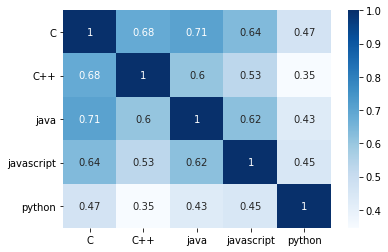

In [34]:
sim = tfidf*tfidf.T
label_names = list(label_dict.values())
sim_df = pd.DataFrame(sim.todense(), columns = label_names, index = label_names)
sns.heatmap(sim_df, annot = True, cmap='Blues')
plt.show()

### 3-(2) 임베딩

In [35]:
title = pd.Series(map(lambda x: pre(str(x)), train.title))
content = pd.Series(map(lambda x: pre(str(x)), train.content))
data = title+content

In [37]:
# 각 문서 간 (언어 간) 유사도가 상당히 높은 편이다. 따라서 tfidf로 임베딩 할 때 max_df 인자를 추가시킨다.
fixed_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.8,
    ngram_range=(1,5),
    lowercase=False,
#     stop_words=stoplist,
    tokenizer=tokenizer)

fixed_tfidf = fixed_vectorizer.fit_transform(data)
fixed_tfidf.shape

(2592, 7155)

In [38]:
features = fixed_tfidf.toarray()
labels = train.label

In [39]:
features.shape, labels.shape

((2592, 7155), (2592,))

# 4. 학습

### 4-(1) 여러 모델 성능 비교

In [40]:
x_train, x_test, y_train, y_test = train_test_split(
      data, train.label, stratify=train.label, # data는 텍스트 전처리가 끝나있는 상태
      random_state=0, test_size=0.25)

In [41]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# 빠른 테스트를 위해 세부적인 파라미터는 일단 무시
_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',SVC())
])
_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [42]:
pipe_train_score = _pipe.score(x_train, y_train)
pipe_test_score = _pipe.score(x_test, y_test)

In [43]:
pipe_train_score, pipe_test_score

(0.9984567901234568, 0.7222222222222222)

In [44]:
parameters = {'clf__kernel':['linear','rbf','poly']}

In [36]:
grid = GridSearchCV(_pipe, parameters, cv=5, n_jobs=-1)

In [37]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [38]:
print('optimal parameter is {}'.format(grid.best_params_))
print('best CV score is {:.3f}'.format(grid.best_score_))
print('best test score is {:.3f}'.format(grid.score(x_test, y_test)))

optimal parameter is {'clf__kernel': 'linear'}
best CV score is 0.747
best test score is 0.799


In [45]:
def get_score(pipe):
    pipe.fit(x_train, y_train)
    pipe_train_score = pipe.score(x_train, y_train)
    pipe_test_score = pipe.score(x_test, y_test)
    print('train score is {:.4f}'.format(pipe_train_score))
    print('test score is {:.4f}'.format(pipe_test_score))

In [41]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',SVC(kernel='linear'))
])
get_score(pipe)

train score is 0.9943
test score is 0.7994


In [42]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',LinearSVC())
])
get_score(pipe)

train score is 1.0000
test score is 0.8025


위의 결과를 통해 linearSVC()를 사용해도 무방하다는 사실을 확인할 수 있다.  
(엄밀히 따지면 SVC(kernel='linear)와 LinearSVC()는 그 결과값이 약간은 다르지만,  
LinearSVC()가 조금 더 빠르고 값이 잘 나온다.)

모델을 LinearSVC()로 확정하고, 다음 파라미터 튜닝을 진행한다.

### 5-(2) 그리드서치

In [46]:
pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf',LinearSVC())
])
get_score(pipe)

train score is 1.0000
test score is 0.7485


토크나이저를 사용하면 score가 올라가긴 하지만 연산이 너무 오래 걸린다. 토크나이저를 따로 추가하는 것은 다른 파라미터 튜닝 후, 마지막 단계에서 수행한다.

In [47]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
#         stop_words=stoplist,
        tokenizer=tokenizer
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

train score is 1.0000
test score is 0.7701


In [48]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,3),
        lowercase=False,
#         stop_words=stoplist,
        tokenizer=tokenizer
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

train score is 1.0000
test score is 0.7623


In [49]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,5),
        lowercase=False,
#         stop_words=stoplist,
        tokenizer=tokenizer
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

train score is 1.0000
test score is 0.7577


### 5-(3) 최종 모델 선택 후 결과 예측

In [52]:
# 문서 토큰화를 미리 진행해보고, '질문글'의 특성 상 나타날 수 밖에 없는 토큰들을 stop_words로 추가한다.
stoplist = ['▁가', '▁가다', '▁감사', '▁감사하다', '▁같이', '▁게', '▁경우', '▁과', '▁궁금', '▁궁금하다', '▁그', '▁는', '▁늘', '▁늘다', '▁다', '▁다음', '▁도', '▁도움', '▁되', '▁되다', '▁되어다', '▁드리', '▁들', '▁들다', '▁또는', '▁뜨', '▁뜨다', '▁라고', '▁라는', '▁로', '▁를', '▁만', '▁모르', '▁모르다', '▁못', '▁문제', '▁발생', '▁변수', '▁보', '▁보다', '▁부탁', '▁부탁드리다', '▁싶', '▁싶다', '▁아니', '▁아니다', '▁아래', '▁안', '▁안녕', '▁안녕하다', '▁않', '▁않다', '▁어', '▁어다', '▁어떻', '▁어떻다', '▁없', '▁없다', '▁에', '▁에는', '▁에러', '▁에서', '▁에서는', '▁예', '▁오다', '▁오류', '▁와', '▁왜', '▁으로', '▁은', '▁을', '▁의', '▁이', '▁이다', '▁이런', '▁이렇', '▁이렇게', '▁이렇다', '▁있', '▁있다', '▁저런', '▁죠', '▁주', '▁질문', '▁코드', '▁필요', '▁필요하다', '▁하', '▁하다', '▁해', '▁해보다', '▁해주다']

In [53]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=tokenizer
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5))
])
get_score(pipe)

pipe.fit(x_train, y_train)

train score is 1.0000
test score is 0.7608


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=0.3,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['▁가', '▁가다', '▁감사', '▁감사하다', '▁같이',
                                             '▁게', '▁경우', '▁과', '▁궁금', '▁궁금하다',
                                             '▁그', '▁는', '▁늘', '▁늘다', '▁다...
                                 tokenizer=<function <lambda> at 0x0000025AC506EF78>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=False,
                                  sublinear_tf=True, use_idf=True)),
      

word 단위로 sentencepiece 토크나이징 할 경우 끔찍한 결과가 나온다... 왜일까? 코퍼스가 너무 적은 탓일까? vocab_size가 너무 작았을까? vocab_size를 열배 증가시켜 다시 해보자.

In [55]:
spm.SentencePieceTrainer.Train('--input=C:\Python\Ground\data\hashcode\hashcode_classification2020_train.csv --model_prefix=word2 --vocab_size=10000 --model_type=word')

True

In [56]:
sp.Load("word2.model")

True

In [57]:
sp.EncodeAsPieces(d1[:100])

['▁$$$',
 '▁순서정리',
 '▁오류',
 '▁질문',
 '▁//',
 '▁$$$',
 '▁include',
 '▁<stdio.h>',
 '▁include',
 '▁<stdlib.h>',
 '▁include',
 '▁<time.h>',
 '▁int',
 '▁main()',
 '▁{',
 '▁int',
 '▁ArrRo']

In [58]:
tokenizer = lambda x:sp.EncodeAsPieces(x)

In [59]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=tokenizer
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5))
])
get_score(pipe)

train score is 1.0000
test score is 0.7840


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=0.3,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['▁가', '▁가다', '▁감사', '▁감사하다', '▁같이',
                                             '▁게', '▁경우', '▁과', '▁궁금', '▁궁금하다',
                                             '▁그', '▁는', '▁늘', '▁늘다', '▁다...
                                 tokenizer=<function <lambda> at 0x0000025AD3390CA8>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=False,
                                  sublinear_tf=True, use_idf=True)),
      

In [62]:
spm.SentencePieceTrainer.Train('--input=C:\Python\Ground\data\hashcode\hashcode_classification2020_train.csv --model_prefix=word3 --vocab_size=50000 --model_type=word')

True

In [63]:
sp.Load("word3.model")

True

In [64]:
sp.EncodeAsPieces(d1[:100])

['▁$$$',
 '▁순서정리',
 '▁오류',
 '▁질문',
 '▁//',
 '▁$$$',
 '▁include',
 '▁<stdio.h>',
 '▁include',
 '▁<stdlib.h>',
 '▁include',
 '▁<time.h>',
 '▁int',
 '▁main()',
 '▁{',
 '▁int',
 '▁ArrRo']

In [65]:
tokenizer = lambda x:sp.EncodeAsPieces(x)

In [66]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=tokenizer
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5))
])
get_score(pipe)

train score is 1.0000
test score is 0.7901


조금씩 개선되고 있긴 하지만 mecab이나 konlpy의 결과를 단박에 뛰어넘지는 못한다.  
일상용어(질문글)과 전공용어(코드)가 섞여 있기 때문에, 코퍼스가 그 안에서 다시 분할되기 때문에 학습의 효과가 더 낮아지지 않을까 싶다. 또한 단어 단위라 한국어의 특성 상 토크나이징을 잘 못한다.

In [67]:
tokenizer(d1)

['▁$$$',
 '▁순서정리',
 '▁오류',
 '▁질문',
 '▁//',
 '▁$$$',
 '▁include',
 '▁<stdio.h>',
 '▁include',
 '▁<stdlib.h>',
 '▁include',
 '▁<time.h>',
 '▁int',
 '▁main()',
 '▁{',
 '▁int',
 '▁ArrRoom[',
 '▁=',
 '▁{};srand(time(NULL));for',
 '▁(int',
 '▁i',
 '▁=',
 '▁i',
 '▁<',
 '▁i++)//',
 '▁ArrRoom',
 '▁배열에',
 '▁~',
 '▁지',
 '▁난수로▁입력함',
 '▁{',
 '▁int',
 '▁ran',
 '▁=',
 '▁(rand()',
 '▁%',
 '▁+',
 '▁ArrRoom[i]',
 '▁=',
 '▁ran;▁}for',
 '▁(int',
 '▁i',
 '▁=',
 '▁sizeof(ArrRoom)/sizeof(int)-▁i++)//',
 '▁순서',
 '▁정리',
 '▁{',
 '▁int',
 '▁change',
 '▁=',
 '▁//',
 '▁값',
 '▁저장',
 '▁변수',
 '▁if',
 '▁(ArrRoom[i]',
 '▁>',
 '▁ArrRoom[i+)',
 '▁{',
 '▁change',
 '▁=',
 '▁ArrRoom[i+;▁ArrRoom[i+',
 '▁=',
 '▁ArrRoom[i];',
 '▁ArrRoom[i]',
 '▁=',
 '▁change;',
 '▁}',
 '▁}for',
 '▁(int',
 '▁i',
 '▁=',
 '▁sizeof(ArrRoom)/sizeof(int);',
 '▁i++)',
 '▁//',
 '▁실행결과',
 '▁출력',
 '▁{',
 '▁printf("%d',
 '▁"',
 '▁ArrRoom[i]);',
 '▁}return',
 '▁}',
 '▁까지',
 '▁난수를',
 '▁받아',
 '▁순서대로',
 '▁정렬하려',
 '▁하는데',
 '▁실행하면',
 '▁"Segmentation',
 '▁fault